In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
import matplotlib.pyplot as plt

def clean_windmill(im):
	# Compute the 2D Fourier Transform
	f = fft2(im)
	fshift = fftshift(f)
	
	# Get the magnitude spectrum
	magnitude_spectrum = np.log(np.abs(fshift) + 1)
	
	# Display the magnitude spectrum
	plt.figure(figsize=(5, 5))
	plt.imshow(magnitude_spectrum, cmap='gray')
	plt.title('Magnitude Spectrum')
	plt.show()
	
	rows, cols = im.shape
	crow, ccol = rows // 2 , cols // 2
	
	# Find abnormally large coefficients in the magnitude spectrum
	mask = np.ones((rows, cols), np.uint8)
	threshold = 1e5
	for i in range(rows):
		for j in range(cols):
			# Skip the center of the magnitude spectrum (radius 10)
			if (i - crow)**2 + (j - ccol)**2 <= 10**2:
				continue
			# Check if the magnitude of the Fourier coefficient is greater than the threshold
			if np.abs(fshift[i, j]) > threshold:
				mask[i, j] = 0
	
	# Apply the mask
	fshift = fshift * mask

	masked_magnitude_spectrum = np.log(np.abs(fshift) + 1)
	plt.figure(figsize=(5, 5))
	plt.imshow(masked_magnitude_spectrum, cmap='gray')
	plt.title('Masked Magnitude Spectrum')
	plt.show()
	
	# Inverse Fourier Transform to get the cleaned image
	f_ishift = ifftshift(fshift)
	img_back = ifft2(f_ishift)
	img_back = np.abs(img_back)
	
	return img_back

In [ ]:
im2 = cv2.imread(r'Images/windmill.tif')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im2_clean = clean_windmill(im2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im2, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im2_clean, cmap='gray', vmin=0, vmax=255)

In [9]:
def clean_umbrella(im):
    psf_size = 15  # Size of the PSF
    angle = 45  # Angle for motion blur

    # Create a small PSF for motion blur
    psf = np.zeros((psf_size, psf_size), dtype=np.float64)
    center = psf_size // 2
    for i in range(psf_size):
        x = center + int(np.round(i * np.sin(np.radians(angle))))
        y = center + int(np.round(i * np.cos(np.radians(angle))))
        if 0 <= x < psf_size and 0 <= y < psf_size:
            psf[x, y] = 1
    psf /= psf.sum()  # Normalize PSF

    # Embed PSF into a larger zero matrix matching image size
    padded_psf = np.zeros_like(im, dtype=np.float64)
    psf_start = (padded_psf.shape[0] - psf_size) // 2
    psf_end = psf_start + psf_size
    padded_psf[psf_start:psf_end, psf_start:psf_end] = psf

    # Perform Fourier transforms
    im_fft = fft2(im)
    psf_fft = fft2(padded_psf, s=im.shape)
    epsilon = 1e-5
    psf_fft = np.where(np.abs(psf_fft) < epsilon, epsilon, psf_fft)
    inverse_fft = im_fft / psf_fft
    deconvolved = np.abs(ifft2(inverse_fft))

    return np.clip(deconvolved, 0, 255).astype(np.uint8)

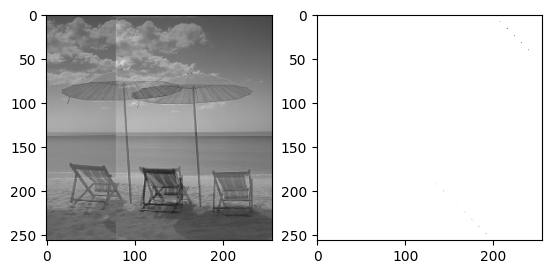

In [10]:
im4 = cv2.imread(r'Images/umbrella.tif')
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
im4_clean = clean_umbrella(im4)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im4, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im4_clean, cmap='gray', vmin=0, vmax=255)

In [ ]:
if __name__ == "__main__":

    print("-----------------------image 1----------------------\n")
    im1 = cv2.imread(r'Images\baby.tif')
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im1_clean = clean_baby(im1)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(im1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im1_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 2----------------------\n")
    im2 = cv2.imread(r'Images\windmill.tif')
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im2_clean = clean_windmill(im2)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im2, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im2_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 3----------------------\n")
    im3 = cv2.imread(r'Images\watermelon.tif')
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
    im3_clean = clean_watermelon(im3)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im3, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im3_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 4----------------------\n")
    im4 = cv2.imread(r'Images\umbrella.tif')
    im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
    im4_clean = clean_umbrella(im4)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im4, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im4_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 5----------------------\n")
    im5 = cv2.imread(r'Images\USAflag.tif')
    im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
    im5_clean = clean_USAflag(im5)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im5, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im5_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 6----------------------\n")
    im6 = cv2.imread(r'Images\house.tif')
    im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
    im6_clean = clean_house(im6)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im6, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im6_clean, cmap='gray', vmin=0, vmax=255)

    print("-----------------------image 7----------------------\n")
    im7 = cv2.imread(r'Images\bears.tif')
    im7 = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
    im7_clean = clean_bears(im7)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im7, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.imshow(im7_clean, cmap='gray', vmin=0, vmax=255)

    plt.show()
